# Chatbot Reading Existing Memories

In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage


from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [ ]:
store = InMemoryStore()

user_id = 'u1'

user_details = ("user",user_id,"details")

store.put(user_details, "profile_1", {"data": "Name: Tushar Gandhi"})
store.put(user_details, "profile_2", {"data": "Profession: Software Developer"})
store.put(user_details, "preference_1", {"data": "Prefers concise answers"})
store.put(user_details, "preference_2", {"data": "Likes examples in Python"})
store.put(user_details, "project_1", {"data": "Building MCP servers (Python-based project)"})

In [3]:
# 2) System prompt template (your prompt)
# ----------------------------
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Nitish...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP  server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." 
say "Since your project is built with TypeScript..."

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
""" 

In [8]:
# Create LLm instance
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [11]:
def chat_node(state: MessagesState,config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']["user_id"]

    # Read -only: fetch user details memory
    user_details = ("user",user_id,"details")
    items = store.search(user_details)

    if items:
        user_details_content = "\n".join(f"- {it.value.get('data','')}" for it in items)
    else:
        user_details_content = ""

    system_prompt = SYSTEM_PROMPT_TEMPLATE.format(
        user_details_content=user_details_content
    )

    system_msg = SystemMessage(content=system_prompt)

    response = llm.invoke([system_msg] + state['messages'])

    return {'messages':response}

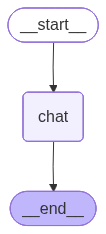

In [12]:
builder = StateGraph(MessagesState)

builder.add_node("chat",chat_node)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

graph

In [13]:
config = {'configurable':{"user_id":"u1"}}

result = graph.invoke(
    {"messages":[{'role':"user","content":"Explain gen ai in simple terms"}]},
    config,
)

print(result["messages"][-1].content)

Hey Tushar, great question!

In simple terms, **Generative AI** is a type of artificial intelligence that can **create brand new things** that have never existed before.

Think of it like this:
*   Instead of just recognizing a cat in a picture, a Generative AI can *draw a brand new picture of a cat* from scratch, or even create a whole new species of cat!
*   It doesn't just find existing answers; it *generates* novel outputs.

So, if you ask it to "write a story about a space explorer," it doesn't search the internet for stories; it literally *writes* a new one. This applies to text, images, music, code, and even things like 3D models.

For your Python-based MCP server project, imagine an AI that could generate new game levels, unique item descriptions, or even help write Python code snippets for new features – that's the power of Generative AI!

---

Here are 3 further questions you might find interesting, Tushar:

1.  What are some common Generative AI models that I could explore f

# ChatBot creating New Memories

In [14]:
from dotenv import load_dotenv
load_dotenv()

import uuid
from typing import List
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage


from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

In [16]:
# create store
store = InMemoryStore()

In [17]:
# information extractor llm
extractor_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [18]:
class MemoryDecision(BaseModel):
    should_write: bool = Field(description="whether to store andy memories")
    memories: List[str] = Field(default_factory=list,description="Atomic User memories to store")

In [19]:
memory_extractor = extractor_llm.with_structured_output(MemoryDecision)

In [ ]:
def remember_only_node(state: MessagesState,config: RunnableConfig,store: BaseStore):

    user_id = config['configurable']['user_id']

    namespace = ("user",user_id,"details")

    last_msg = state['messages'][-1].content

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(
                content=(
                    "Extract LONG-TERM memories from the user's message.\n"
                    "Only store stable, user-specific info (identity, preferences, ongoing projects).\n"
                    "Do NOT store transient info.\n"
                    "Return should_write=false if nothing is worth storing.\n"
                    "Each memory should be a short atomic sentence."
                )
            ),
            {"role":"user","content":last_msg},
        ]
    )

    if decision.should_write:

        for mem in decision.memories:
            store.put(namespace,str(uuid.uuid4()),{"data":mem})

            
    return {"messages":[{"role":"assistant","content":"Noted."}]}

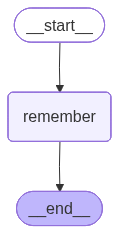

In [25]:
builder = StateGraph(MessagesState)
builder.add_node("remember",remember_only_node)
builder.add_edge(START, "remember")
builder.add_edge("remember", END)

graph = builder.compile(store=store)

graph

In [26]:
config = {'configurable':{"user_id":"u1"}}

res = graph.invoke({"messages":[{"role":"user","content":"Hi my name is Tushar Gandhi"}]},config)

print("Assistant:",res["messages"][-1].content)

Assistant: Noted.


In [27]:
res = graph.invoke({"messages": [{"role": "user", "content": "I teach AI on youtube"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [28]:
res = graph.invoke({"messages": [{"role": "user", "content": "My favorite programming language is Python"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [30]:
items = store.search(("user",'u1',"details"))

for item in items:
    print(item.value)

{'date': "User's name is Tushar Gandhi."}
{'date': 'The user teaches AI on YouTube.'}
{'date': "The user's favorite programming language is Python."}
